In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt

sys.path.append('..')
file_path = '../data/processed/notebooks/master_analytical_file.parquet'

if os.path.exists(file_path):
    df_master = pd.read_parquet(file_path)
    print(f"Loaded Master Data: {len(df_master):,} rows")
    print(f"Date range: {df_master['shipped_dt'].min()} to {df_master['shipped_dt'].max()}")
else:
    print("Error: Master file not found. Please run Notebook 02 first.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded Master Data: 1,983,549 rows
Date range: 2025-01-01 00:00:00.275000 to 2025-12-31 21:40:11


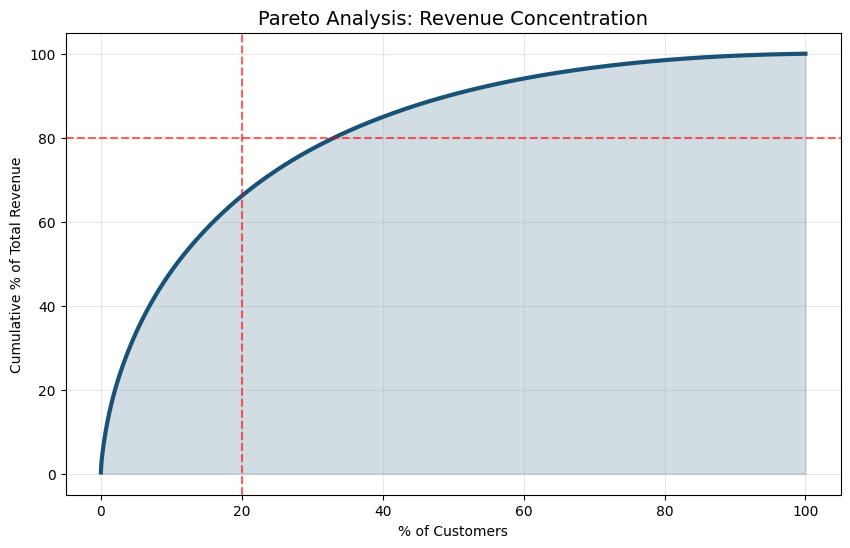

In [3]:
# Pareto Analysis: Revenue Concentration

revenue_per_cust = df_master[df_master['type'] == 'SALE'].groupby('trade_account_id')['netrevenue'].sum().sort_values(ascending=False).reset_index()
revenue_per_cust['cum_pct'] = revenue_per_cust['netrevenue'].cumsum() / revenue_per_cust['netrevenue'].sum() * 100
revenue_per_cust['cust_pct'] = (revenue_per_cust.index + 1) / len(revenue_per_cust) * 100


plt.figure(figsize=(10, 6))
plt.plot(revenue_per_cust['cust_pct'], revenue_per_cust['cum_pct'], color='#1A5276', linewidth=3)
plt.fill_between(revenue_per_cust['cust_pct'], revenue_per_cust['cum_pct'], alpha=0.2, color='#1A5276')
plt.axhline(80, color='red', linestyle='--', alpha=0.6)
plt.axvline(20, color='red', linestyle='--', alpha=0.6)

plt.title('Pareto Analysis: Revenue Concentration', fontsize=14)
plt.xlabel('% of Customers')
plt.ylabel('Cumulative % of Total Revenue')
plt.grid(True, alpha=0.3)
plt.show()

C:\Users\P.Avinash\AppData\Local\Temp\ipykernel_22756\586901959.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  basket = df_master[df_master['type'] == 'SAMPLE'].groupby(['order_id', 'category_name']).size().unstack().fillna(0)
C:\Users\P.Avinash\AppData\Local\Temp\ipykernel_22756\586901959.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


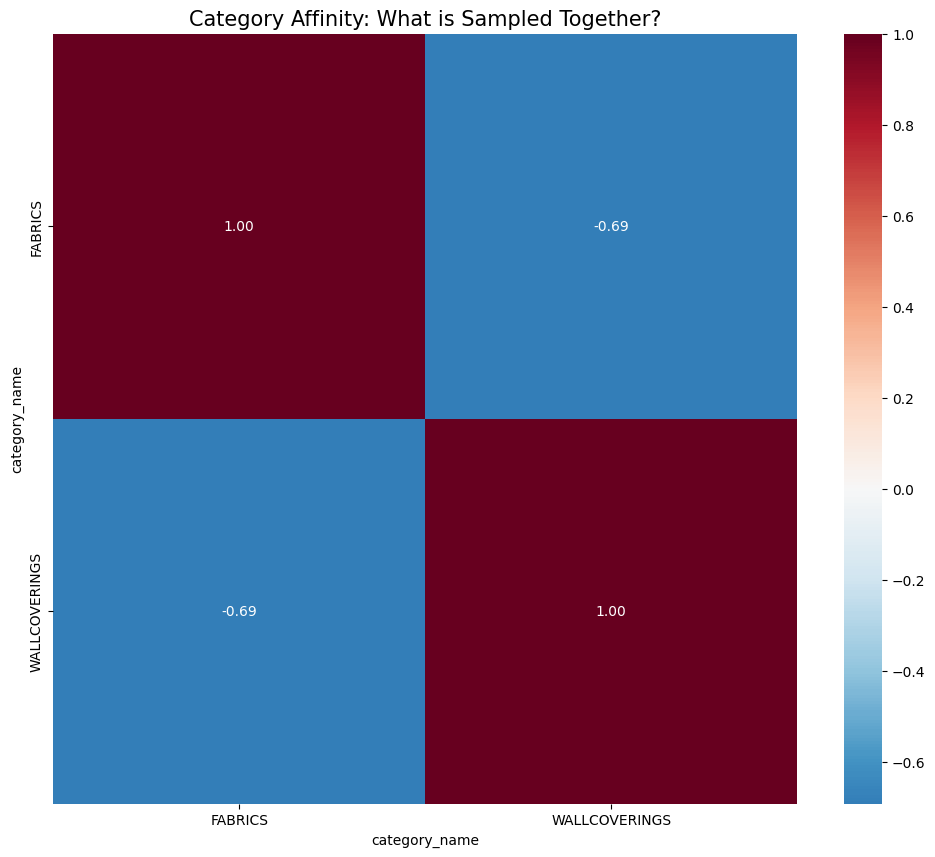

In [5]:
# Category Affinity Analysis: What is Sampled Together?

basket = df_master[df_master['type'] == 'SAMPLE'].groupby(['order_id', 'category_name']).size().unstack().fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)
item_affinity = basket.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(item_affinity, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Category Affinity: What is Sampled Together?', fontsize=15)
plt.show()

C:\Users\P.Avinash\AppData\Local\Temp\ipykernel_22756\1672660711.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_stats = df_master.groupby(['price_bracket', 'type'])['trade_account_id'].nunique().unstack().fillna(0)
C:\Users\P.Avinash\AppData\Local\Temp\ipykernel_22756\1672660711.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=plot_data.index, y=plot_data['CR_Percent'], palette='flare')


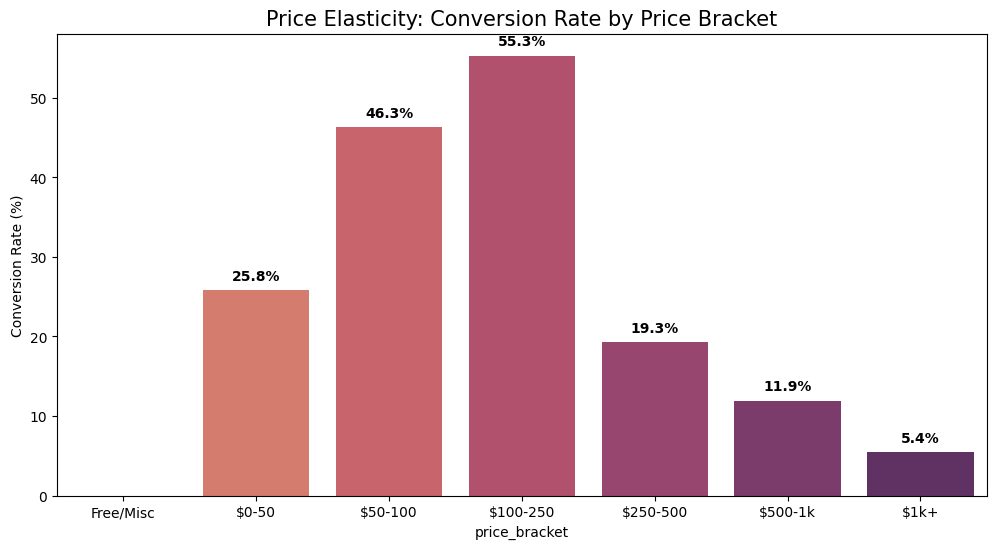

In [ ]:
sales_only = df_master[df_master['type'] == 'SALE'].copy()
sales_only['unit_price'] = sales_only['netrevenue'] / sales_only['quantity'].replace(0, 1)
item_prices = sales_only.groupby('item_number')['unit_price'].median().reset_index()

df_master = df_master.drop(columns=['unit_price'], errors='ignore') 
df_master = df_master.merge(item_prices, on='item_number', how='left')

df_master['unit_price'] = df_master['unit_price'].fillna(0)

price_bins = [0, 0.01, 50, 100, 250, 500, 1000, 100000] 
price_labels = ['Free/Misc', '$0-50', '$50-100', '$100-250', '$250-500', '$500-1k', '$1k+']
df_master['price_bracket'] = pd.cut(df_master['unit_price'], bins=price_bins, labels=price_labels)

price_stats = df_master.groupby(['price_bracket', 'type'])['trade_account_id'].nunique().unstack().fillna(0)

if 'SALE' in price_stats.columns and 'SAMPLE' in price_stats.columns:
    price_stats['CR_Percent'] = (price_stats['SALE'] / price_stats['SAMPLE']) * 100
    price_stats['CR_Percent'] = price_stats['CR_Percent'].replace([float('inf'), -float('inf')], 0).fillna(0)
    

    plt.figure(figsize=(12, 6))
    plot_data = price_stats.iloc[1:] 
    
    ax = sns.barplot(x=plot_data.index, y=plot_data['CR_Percent'], palette='flare')

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontweight='bold', xytext=(0, 5), textcoords='offset points')

    plt.title('Price Elasticity: Conversion Rate by Price Bracket', fontsize=15)
    plt.ylabel('Conversion Rate (%)')
    plt.show()
else:
    print("Check your data! Current counts:")
    print(df_master['type'].value_counts())

C:\Users\P.Avinash\AppData\Local\Temp\ipykernel_22756\2999997110.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  motif_revenue = df_master[df_master['type'] == 'SALE'].groupby('motif')['netrevenue'].sum().sort_values(ascending=False).head(10)


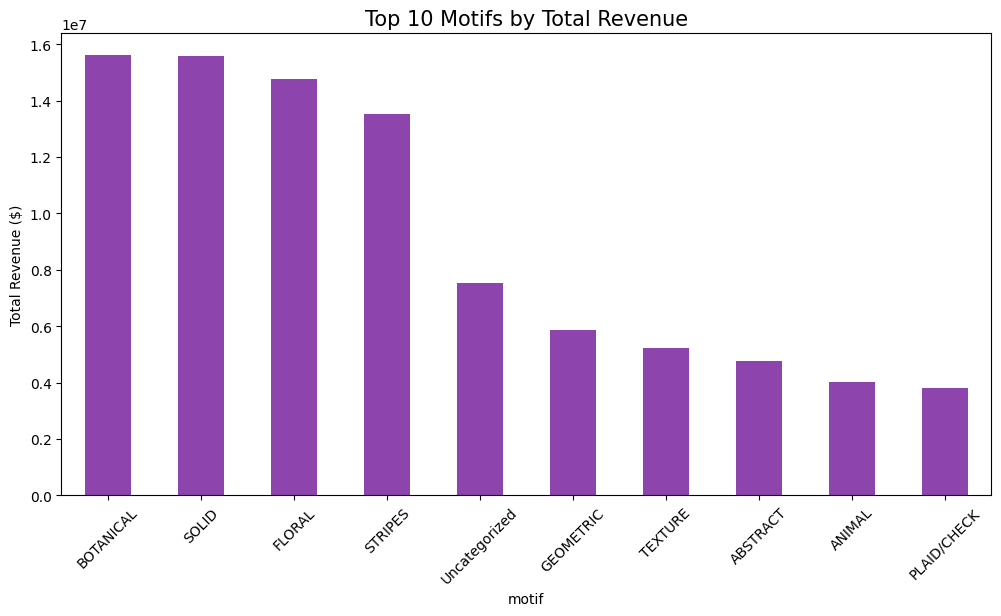

In [7]:
motif_revenue = df_master[df_master['type'] == 'SALE'].groupby('motif')['netrevenue'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
motif_revenue.plot(kind='bar', color='#8E44AD')
plt.title('Top 10 Motifs by Total Revenue', fontsize=15)
plt.ylabel('Total Revenue ($)')
plt.xticks(rotation=45)
plt.show()